In [ ]:
import sys
print("Python Version:", sys.version)

Python Version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


The window_size determines the size of the rolling window. The rolling mean and standard deviation are calculated over this window, providing a dynamic measure of the typical behavior of the data. The dynamic threshold is then set as a multiple of the rolling standard deviation.



## Autoencoder

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
import pandas as pd

In [3]:
pd.set_option('display.max_columns', 500)
import pandas as pd
train = pd.read_csv("/content/train.csv")
# train.head()

In [4]:
test = pd.read_csv("/content/test.csv")

In [5]:
X = pd.concat([train, test])
X['Timestamp'] = pd.to_datetime(X['Timestamp'])

In [6]:
X = X[X['Timestamp'] != '2012-09-20 04:00:00+00:00']
X = X[X['Timestamp'] != '2012-09-20 05:00:00+00:00']
X = X[X['Timestamp'] != '2012-08-21 09:00:00+00:00']
X = X[X['Timestamp'] != '2012-08-21 10:00:00+00:00']
X = X[X['Timestamp'] != '2012-08-20 11:00:00+00:00']
X = X[X['Timestamp'] != '2012-08-20 12:00:00+00:00']

In [7]:
df = X.copy()
# X = X.set_index('Timestamp')
# X.sort_index(inplace=True)

import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import numpy as np

df['month'] = df['Timestamp'].dt.month
df['day_of_week'] = df['Timestamp'].dt.dayofweek
df['hour'] = df['Timestamp'].dt.hour
df = df.set_index('Timestamp')
df.sort_index(inplace=True)

# Select features and target variable
X = df[['Temperature', 'holiday', 'prev value', 'twice prev value', 'day shift',
       'month shift', 'month', 'day_of_week', 'hour']]
y = df['tv delta']

In [8]:
X.shape

(48995, 9)

In [9]:
X_train = X[:30000]
X_test = X[30000:40000]
y_train = y[:30000]
y_test = y[30000:40000]
X_validate = X[40000:]
y_validate = y[40000:]
print(f"""Shape of the datasets:
    training (rows, cols) = {X_train.shape}
    validate (rows, cols) = {X_test.shape}
    holdout  (rows, cols) = {X_validate.shape}""")

Shape of the datasets:
    training (rows, cols) = (30000, 9)
    validate (rows, cols) = (10000, 9)
    holdout  (rows, cols) = (8995, 9)


In [10]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])
pipeline.fit(X_train);
X_train_transformed = pipeline.transform(X_train)
X_test_transformed = pipeline.transform(X_test)



## Model architecture

In [12]:
import tensorflow as tf

# data dimensions // hyperparameters
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 256
EPOCHS = 100

# https://keras.io/layers/core/
autoencoder = tf.keras.models.Sequential([

    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(2, activation='elu'),

    # reconstruction / decode
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')

])

# https://keras.io/api/models/model_training_apis/
autoencoder.compile(optimizer="adam",
                    loss="mse",
                    metrics=["acc"])

autoencoder.summary();

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 90        
                                                                 
 dense_1 (Dense)             (None, 16)                160       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 2)                 10        
                                                                 
 dense_5 (Dense)             (None, 4)                 12        
                                                                 
 dense_6 (Dense)             (None, 8)                 4

## Callbacks
- Continue as long as the model is reducing the training loss.
- Save only the weights for the model with the lowest validation loss, though.
- Get graphical insights with Tensorboard.

In [13]:
from datetime import datetime

yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')

log_subdir = f'{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(autoencoder.layers)}'

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.hdf5',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)

tensorboard = tf.keras.callbacks.TensorBoard(
    f'logs/{log_subdir}',
    batch_size=BATCH_SIZE,
    update_freq='batch'
)

cb = [early_stop, save_model, tensorboard]

## Model training

In [14]:
history = autoencoder.fit(
    X_train_transformed, X_train_transformed,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    validation_data=(X_test_transformed, X_test_transformed)
);

Epoch 1/100
118/118 [==============================] - 4s 11ms/step - loss: 0.0494 - acc: 0.3673 - val_loss: 0.0188 - val_acc: 0.4189
Epoch 2/100
 22/118 [====>.........................] - ETA: 0s - loss: 0.0160 - acc: 0.4501

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


118/118 [==============================] - 1s 8ms/step - loss: 0.0140 - acc: 0.4938 - val_loss: 0.0148 - val_acc: 0.5024
Epoch 3/100
118/118 [==============================] - 1s 8ms/step - loss: 0.0104 - acc: 0.5704 - val_loss: 0.0131 - val_acc: 0.5515
Epoch 4/100
118/118 [==============================] - 1s 7ms/step - loss: 0.0096 - acc: 0.5816 - val_loss: 0.0125 - val_acc: 0.5543
Epoch 5/100
118/118 [==============================] - 1s 8ms/step - loss: 0.0093 - acc: 0.5804 - val_loss: 0.0122 - val_acc: 0.5530
Epoch 6/100
118/118 [==============================] - 1s 8ms/step - loss: 0.0090 - acc: 0.5809 - val_loss: 0.0118 - val_acc: 0.5597
Epoch 7/100
118/118 [==============================] - 1s 7ms/step - loss: 0.0087 - acc: 0.5852 - val_loss: 0.0114 - val_acc: 0.5662
Epoch 8/100
118/118 [==============================] - 1s 7ms/step - loss: 0.0083 - acc: 0.5912 - val_loss: 0.0108 - val_acc: 0.5687
Epoch 9/100
118/118 [==============================] - 1s 7ms/step - loss: 0.0078

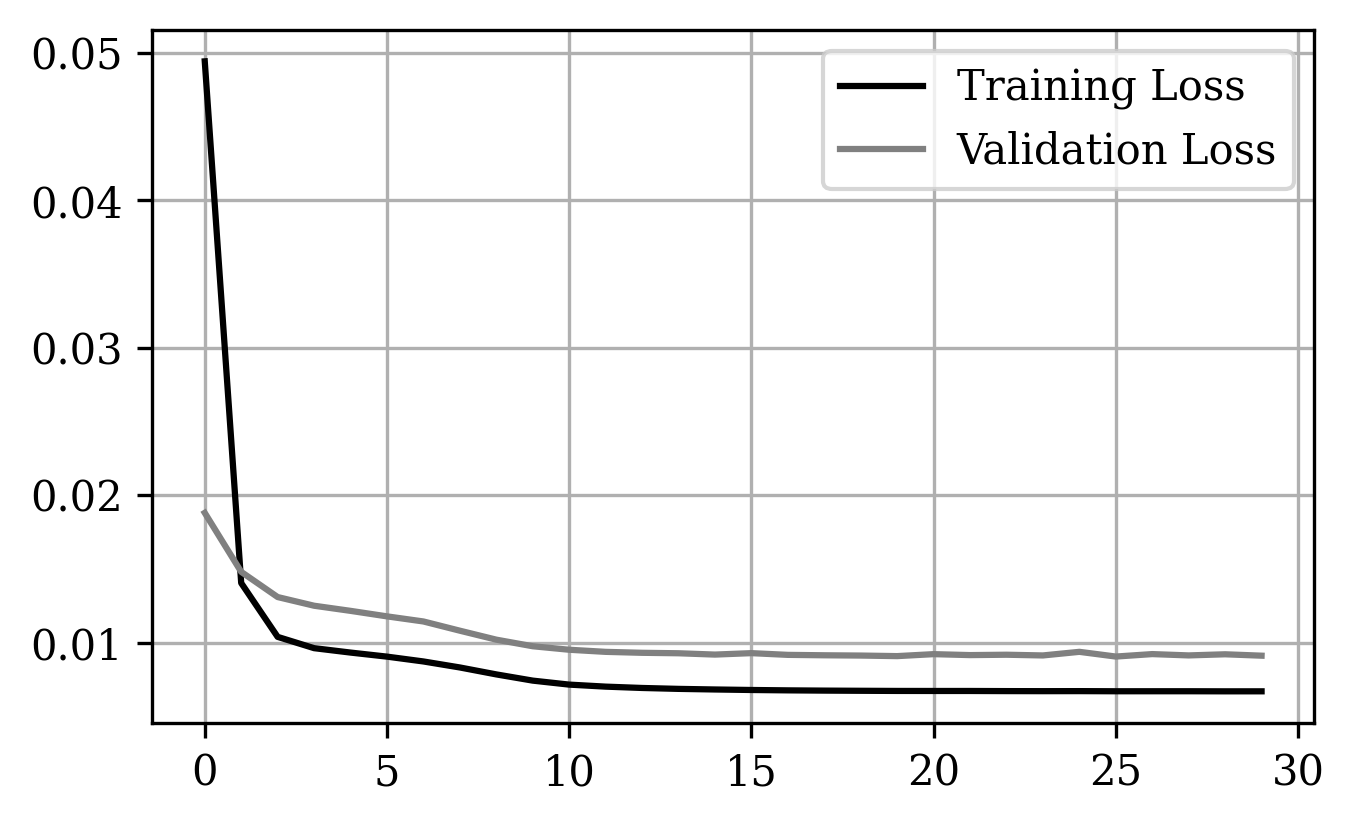

In [15]:
plt.figure(dpi=300, figsize=(5,3))
plt.plot(history.history["loss"], label="Training Loss", color ='k')
plt.plot(history.history["val_loss"], label="Validation Loss", color='gray')
plt.legend()
plt.show()

Epoch 1/100
1875/1875 [==============================] - 12s 5ms/step - loss: 0.0130 - acc: 0.5592 - val_loss: 0.0100 - val_acc: 0.5906
Epoch 2/100
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0072 - acc: 0.5995 - val_loss: 0.0095 - val_acc: 0.5931
Epoch 3/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0068 - acc: 0.5975 - val_loss: 0.0092 - val_acc: 0.5913
Epoch 4/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0068 - acc: 0.6004 - val_loss: 0.0091 - val_acc: 0.5921
Epoch 5/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0068 - acc: 0.6038 - val_loss: 0.0092 - val_acc: 0.5973
Epoch 6/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0067 - acc: 0.6057 - val_loss: 0.0091 - val_acc: 0.5951
Epoch 7/100
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0067 - acc: 0.6061 - val_loss: 0.0090 - val_acc: 0.5943
Epoch 8/100
1875/1875 [=========================

Epoch 1/100
968/968 [==============================] - 35s 6ms/step - loss: 0.0172 - acc: 0.5375 - val_loss: 0.0122 - val_acc: 0.5607
Epoch 2/100
968/968 [==============================] - 5s 5ms/step - loss: 0.0078 - acc: 0.6008 - val_loss: 0.0097 - val_acc: 0.5857
Epoch 3/100
968/968 [==============================] - 6s 6ms/step - loss: 0.0069 - acc: 0.6085 - val_loss: 0.0091 - val_acc: 0.5910
Epoch 4/100
968/968 [==============================] - 5s 5ms/step - loss: 0.0068 - acc: 0.6104 - val_loss: 0.0092 - val_acc: 0.5990
Epoch 5/100
968/968 [==============================] - 6s 6ms/step - loss: 0.0067 - acc: 0.6113 - val_loss: 0.0092 - val_acc: 0.5842
Epoch 6/100
968/968 [==============================] - 6s 6ms/step - loss: 0.0067 - acc: 0.6107 - val_loss: 0.0093 - val_acc: 0.6011
Epoch 7/100
968/968 [==============================] - 5s 6ms/step - loss: 0.0067 - acc: 0.6120 - val_loss: 0.0091 - val_acc: 0.6012
Epoch 8/100
968/968 [==============================] - 6s 7ms/step -

Epoch 1/100
469/469 [==============================] - 5s 7ms/step - loss: 0.0249 - acc: 0.4214 - val_loss: 0.0153 - val_acc: 0.4966
Epoch 2/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0098 - acc: 0.5724 - val_loss: 0.0119 - val_acc: 0.5447
Epoch 3/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0077 - acc: 0.5893 - val_loss: 0.0095 - val_acc: 0.5861
Epoch 4/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0069 - acc: 0.6149 - val_loss: 0.0094 - val_acc: 0.5964
Epoch 5/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0068 - acc: 0.6146 - val_loss: 0.0093 - val_acc: 0.5945
Epoch 6/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0068 - acc: 0.6146 - val_loss: 0.0092 - val_acc: 0.5981
Epoch 7/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0068 - acc: 0.6151 - val_loss: 0.0092 - val_acc: 0.6003
Epoch 8/100
469/469 [==============================] - 3s 6ms/step - 

Epoch 1/100
235/235 [==============================] - 4s 10ms/step - loss: 0.0320 - acc: 0.3534 - val_loss: 0.0179 - val_acc: 0.4299
Epoch 2/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0129 - acc: 0.4548 - val_loss: 0.0123 - val_acc: 0.5375
Epoch 3/100
235/235 [==============================] - 2s 6ms/step - loss: 0.0092 - acc: 0.5741 - val_loss: 0.0116 - val_acc: 0.5514
Epoch 4/100
235/235 [==============================] - 1s 6ms/step - loss: 0.0085 - acc: 0.5850 - val_loss: 0.0107 - val_acc: 0.5604
Epoch 5/100
235/235 [==============================] - 1s 6ms/step - loss: 0.0078 - acc: 0.5938 - val_loss: 0.0099 - val_acc: 0.5661
Epoch 6/100
235/235 [==============================] - 2s 6ms/step - loss: 0.0072 - acc: 0.6008 - val_loss: 0.0094 - val_acc: 0.5776
Epoch 7/100
235/235 [==============================] - 1s 6ms/step - loss: 0.0070 - acc: 0.6060 - val_loss: 0.0093 - val_acc: 0.5832
Epoch 8/100
235/235 [==============================] - 2s 6ms/step -

Epoch 1/100
118/118 [==============================] - 3s 8ms/step - loss: 0.0537 - acc: 0.3115 - val_loss: 0.0191 - val_acc: 0.3686
Epoch 2/100
118/118 [==============================] - 1s 6ms/step - loss: 0.0154 - acc: 0.3747 - val_loss: 0.0164 - val_acc: 0.3723
Epoch 3/100
118/118 [==============================] - 1s 6ms/step - loss: 0.0124 - acc: 0.4271 - val_loss: 0.0137 - val_acc: 0.4588
Epoch 4/100
118/118 [==============================] - 1s 8ms/step - loss: 0.0104 - acc: 0.5676 - val_loss: 0.0131 - val_acc: 0.5563
Epoch 5/100
118/118 [==============================] - 1s 7ms/step - loss: 0.0100 - acc: 0.5870 - val_loss: 0.0129 - val_acc: 0.5564
Epoch 6/100
118/118 [==============================] - 1s 6ms/step - loss: 0.0098 - acc: 0.5857 - val_loss: 0.0128 - val_acc: 0.5560
Epoch 7/100
118/118 [==============================] - 1s 6ms/step - loss: 0.0096 - acc: 0.5871 - val_loss: 0.0124 - val_acc: 0.5581
Epoch 8/100
118/118 [==============================] - 1s 6ms/step - 

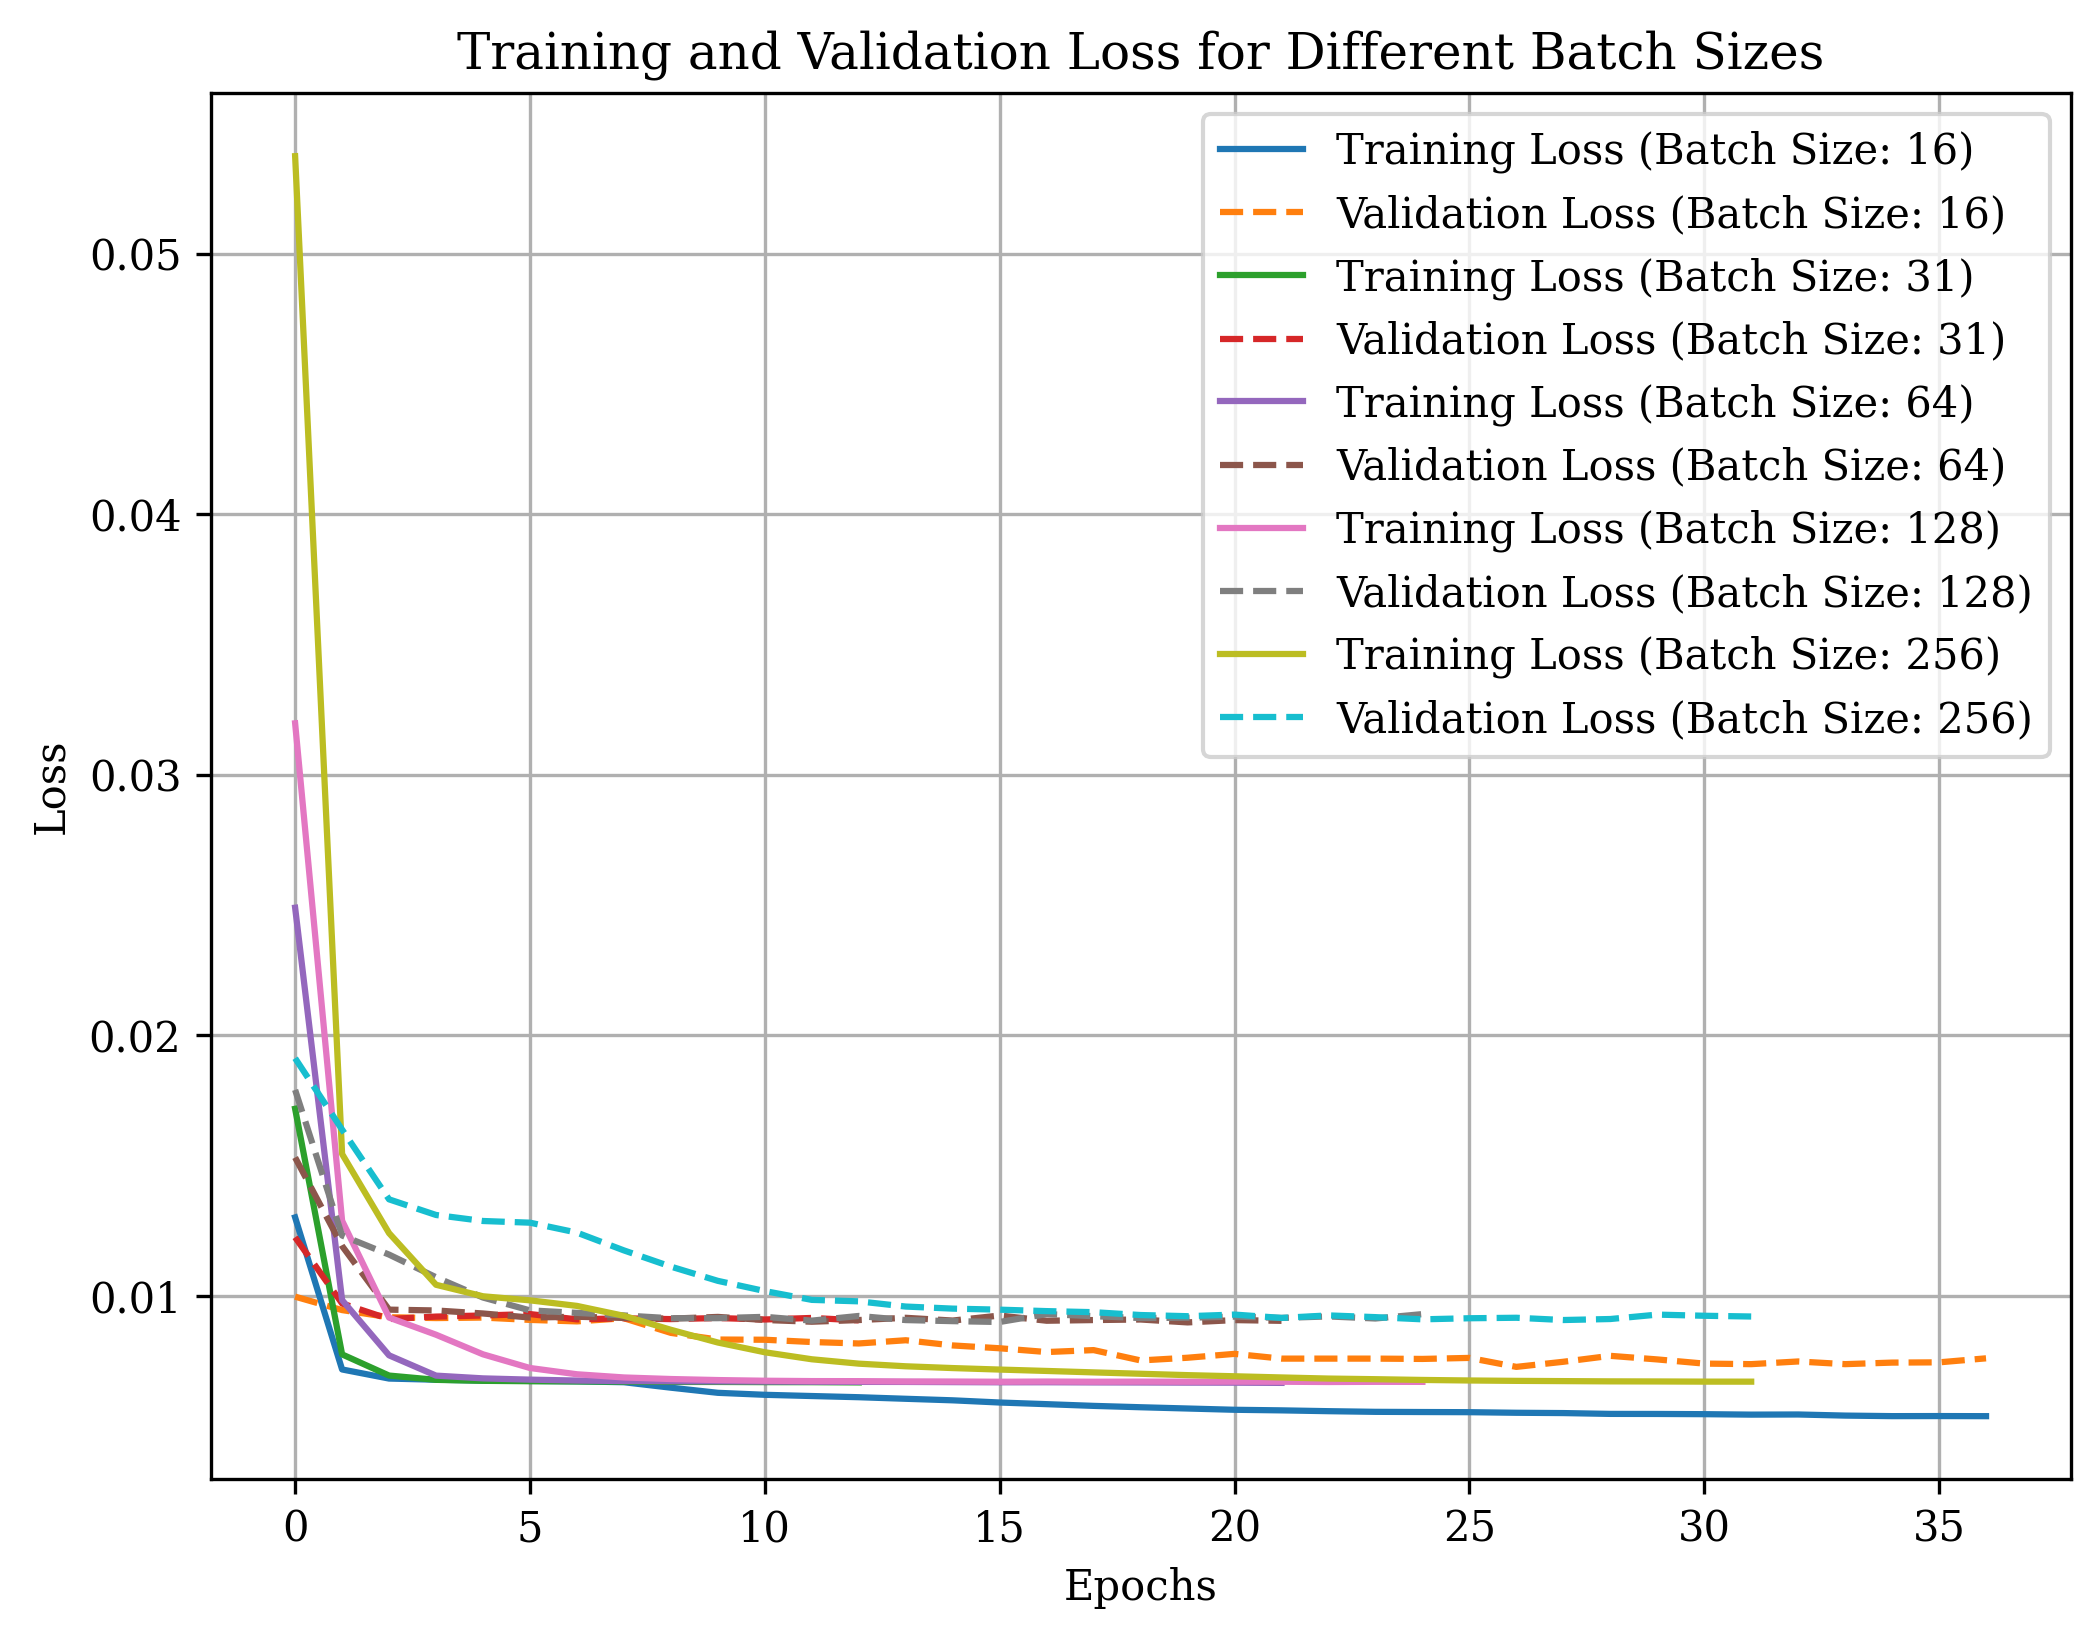

In [ ]:
batch_sizes = [16, 31, 64, 128, 256]

history_dict = {}

for batch_size in batch_sizes:
    # autoencoder model with the specified batch size
    autoencoder = tf.keras.models.Sequential([
        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dense(2, activation='elu'),

        # reconstruction / decode
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dense(input_dim, activation='elu')
    ])


    autoencoder.compile(optimizer="adam",
                        loss="mse",
                        metrics=["acc"])


    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0001,
        patience=10,
        verbose=1,
        mode='min',
        restore_best_weights=True
    )

    save_model = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'autoencoder_best_weights_batch{batch_size}.hdf5',
        save_best_only=True,
        monitor='val_loss',
        verbose=0,
        mode='min'
    )

    tensorboard = tf.keras.callbacks.TensorBoard(
        log_dir=f'logs/{log_subdir}_batch{batch_size}',
        batch_size=batch_size,
        update_freq='batch'
    )


    history = autoencoder.fit(
        X_train_transformed, X_train_transformed,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=batch_size,
        callbacks=[early_stop, save_model, tensorboard],
        validation_data=(X_test_transformed, X_test_transformed)
    )

    history_dict[batch_size] = history

plt.figure(dpi=300, figsize=(8, 6))
for batch_size, history in history_dict.items():
    plt.plot(history.history["loss"], label=f"Training Loss (Batch Size: {batch_size})")
    plt.plot(history.history["val_loss"], label=f"Validation Loss (Batch Size: {batch_size})", linestyle='dashed')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Different Batch Sizes')
plt.legend()
plt.show()



In [ ]:
import numpy as np

error_metrics_dict = {}

for batch_size, history in history_dict.items():
    # predictions on the test set
    reconstructions = autoencoder.predict(X_test_transformed)

    # mean squared error (MSE) and mean absolute error (MAE)
    mse = np.mean(np.square(X_test_transformed - reconstructions))
    mae = np.mean(np.abs(X_test_transformed - reconstructions))

    error_metrics_dict[batch_size] = {'MSE': mse, 'MAE': mae}

for batch_size, metrics in error_metrics_dict.items():
    print(f"Batch Size: {batch_size}")
    print(f"MSE: {metrics['MSE']}")
    print(f"MAE: {metrics['MAE']}")
    print()


313/313 [==============================] - 1s 3ms/step
Batch Size: 16
MSE: 0.009155455609488673
MAE: 0.05894207907838253

Batch Size: 31
MSE: 0.009155455609488673
MAE: 0.05894207907838253

Batch Size: 64
MSE: 0.009155455609488673
MAE: 0.05894207907838253

Batch Size: 128
MSE: 0.009155455609488673
MAE: 0.05894207907838253

Batch Size: 256
MSE: 0.009155455609488673
MAE: 0.05894207907838253



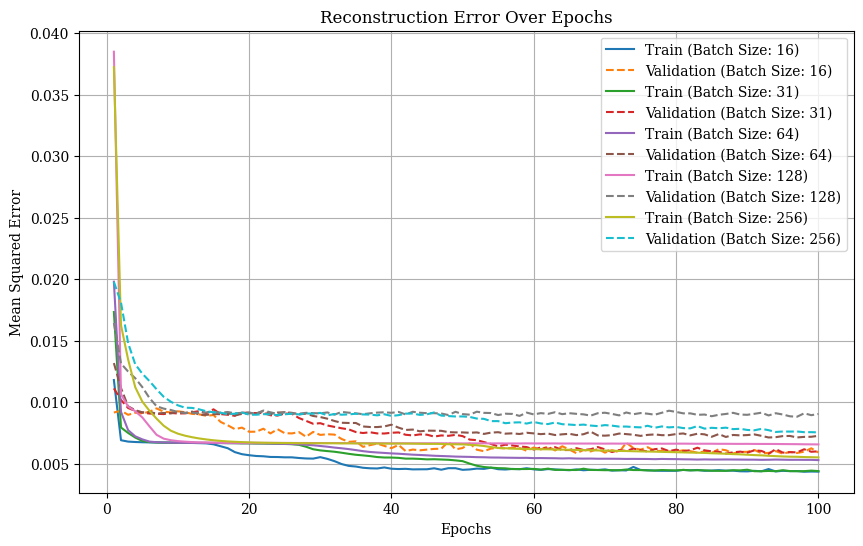

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def build_autoencoder(input_dim):
    autoencoder = tf.keras.models.Sequential([
        # Encoder
        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dense(2, activation='elu'),
        # Decoder
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dense(input_dim, activation='elu')
    ])

    autoencoder.compile(optimizer="adam",
                        loss="mse",
                        metrics=["mae"])

    return autoencoder

def train_autoencoder(X_train_transformed, X_test_transformed, batch_sizes, epochs=100):
    histories = {}

    for batch_size in batch_sizes:
        autoencoder = build_autoencoder(X_train_transformed.shape[1])

        log_subdir = f'{datetime.now().strftime("%Y%m%d%H%M")}_batch{batch_size}'
        tensorboard = tf.keras.callbacks.TensorBoard(f'logs/{log_subdir}', batch_size=batch_size, update_freq='batch')

        history = autoencoder.fit(
            X_train_transformed, X_train_transformed,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[tensorboard],
            validation_data=(X_test_transformed, X_test_transformed),
            verbose=0
        )

        histories[batch_size] = history.history

    return histories

def plot_reconstruction_error(histories):
    plt.figure(figsize=(10, 6))

    for batch_size, history in histories.items():
        mse = history['loss']
        val_mse = history['val_loss']
        epochs = range(1, len(mse) + 1)
        plt.plot(epochs, mse, label=f'Train (Batch Size: {batch_size})', linestyle='-')
        plt.plot(epochs, val_mse, label=f'Validation (Batch Size: {batch_size})', linestyle='--')

    plt.title('Reconstruction Error Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.show()

batch_sizes = [16, 31, 64, 128, 256]
histories = train_autoencoder(X_train_transformed, X_test_transformed, batch_sizes)
plot_reconstruction_error(histories)

## Reconstructions
- We apply the transformation pipeline to our test set.
- Then, we pass the data through the trained autoencoder.

In [16]:
# transform the test set with the pipeline fitted to the training set
X_validate_transformed = pipeline.transform(X_validate)
reconstructions = autoencoder.predict(X_validate_transformed)

282/282 [==============================] - 2s 4ms/step


In [17]:
# mean squared error reconstruction loss per row in the numpy array
mse = np.mean(np.power(X_validate_transformed - reconstructions, 2), axis=1)

313/313 [==============================] - 2s 6ms/step
Number of anomalies in the test data: 360


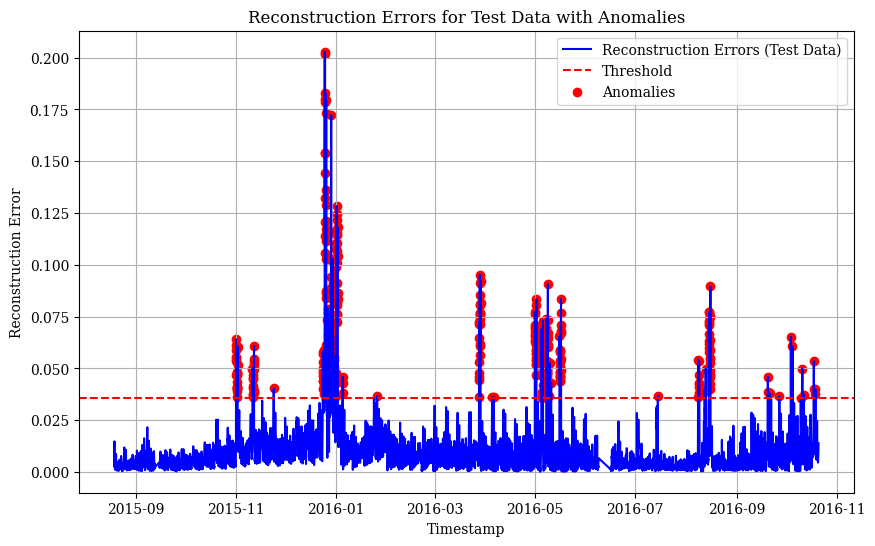

In [19]:
reconstructed_test_data = autoencoder.predict(X_test_transformed)

reconstruction_errors = np.mean(np.square(X_test_transformed - reconstructed_test_data), axis=1)

# Calculate the mean and standard deviation of the reconstruction errors
mean_reconstruction_error = np.mean(reconstruction_errors)
std_reconstruction_error = np.std(reconstruction_errors)

# dynamic threshold
threshold_multiplier = 2
threshold = mean_reconstruction_error + threshold_multiplier * std_reconstruction_error

anomalies_test_indices = np.where(reconstruction_errors > threshold)[0]
normal_indices = np.where(reconstruction_errors <= threshold)[0]


num_anomalies_test = len(anomalies_test_indices)
num_normal_test = len(normal_indices)

print("Number of anomalies in the test data:", num_anomalies_test)

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, reconstruction_errors, label='Reconstruction Errors (Test Data)', color='blue')  # Assuming timestamps start from index 40000
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.scatter(y_test.index[anomalies_test_indices], reconstruction_errors[anomalies_test_indices], color='red', label='Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Errors for Test Data with Anomalies')
plt.legend()
plt.grid(True)
plt.show()


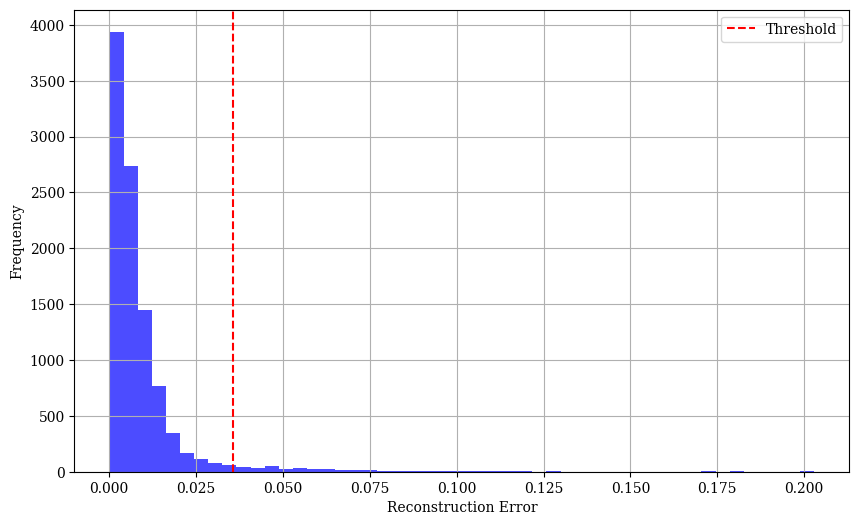

In [21]:
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50, color='blue', alpha=0.7)
plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.legend()
plt.grid(True)
plt.show()


Number of anomalies in the test data: 345


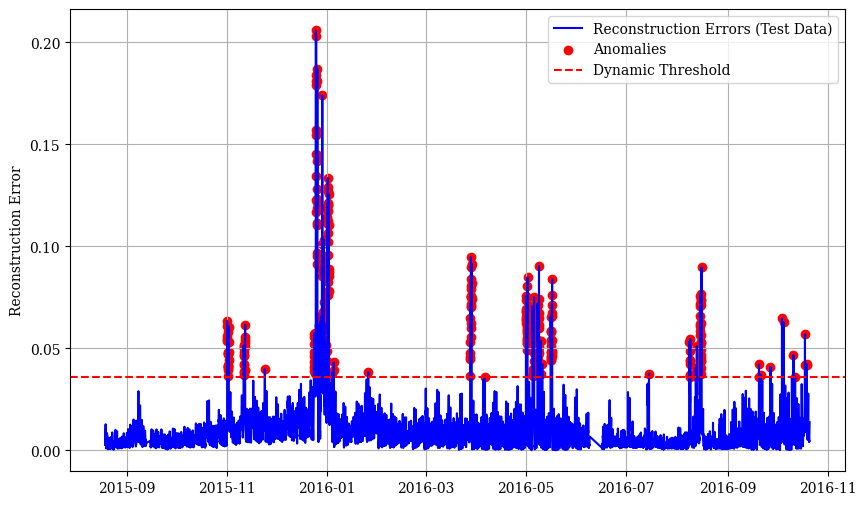

In [ ]:
# mean and standard deviation of the reconstruction errors
mean_reconstruction_error = np.mean(reconstruction_errors)
std_reconstruction_error = np.std(reconstruction_errors)

# dynamic threshold
threshold_multiplier = 2
threshold = mean_reconstruction_error + threshold_multiplier * std_reconstruction_error

# anomalies in the test data based on the dynamic threshold
anomalies_test_indices = np.where(reconstruction_errors > threshold)[0]
normal_indices = np.where(reconstruction_errors <= threshold)[0]

num_anomalies_test = len(anomalies_test_indices)
num_normal_test = len(normal_indices)
print("Number of anomalies in the test data:", num_anomalies_test)

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, reconstruction_errors, label='Reconstruction Errors (Test Data)', color='blue')  # Assuming timestamps start from index 40000
plt.scatter(y_test.index[anomalies_test_indices], reconstruction_errors[anomalies_test_indices], color='red', label='Anomalies')
plt.axhline(y=threshold, color='red', linestyle='--', label='Dynamic Threshold')

plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(True)
plt.show()




282/282 [==============================] - 0s 2ms/step
Number of anomalies in the validation data: 385


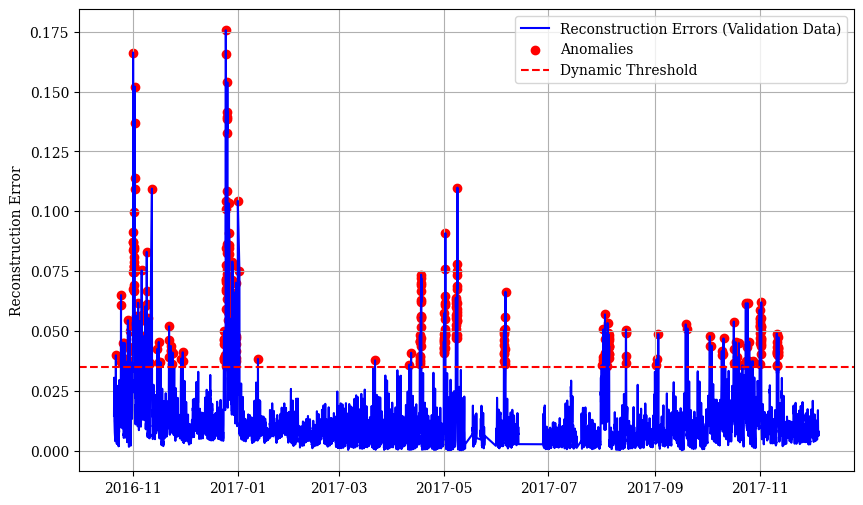

In [ ]:
reconstructed_validation_data = autoencoder.predict(X_validate_transformed)

# reconstruction error for each data point in the validation set
reconstruction_errors_validation = np.mean(np.square(X_validate_transformed - reconstructed_validation_data), axis=1)

# mean and standard deviation of the reconstruction errors
mean_reconstruction_error_validation = np.mean(reconstruction_errors_validation)
std_reconstruction_error_validation = np.std(reconstruction_errors_validation)

# Set the dynamic threshold for the validation set
threshold_multiplier = 2
threshold_validation = mean_reconstruction_error_validation + threshold_multiplier * std_reconstruction_error_validation

# Identify anomalies in the validation data based on the dynamic threshold
anomalies_validation_indices = np.where(reconstruction_errors_validation > threshold_validation)[0]
normal_indices_validation = np.where(reconstruction_errors_validation <= threshold_validation)[0]

num_anomalies_validation = len(anomalies_validation_indices)
print("Number of anomalies in the validation data:", num_anomalies_validation)

plt.figure(figsize=(10, 6))
plt.plot(y_validate.index, reconstruction_errors_validation, label='Reconstruction Errors (Validation Data)', color='blue')
plt.scatter(y_validate.index[anomalies_validation_indices], reconstruction_errors_validation[anomalies_validation_indices], color='red', label='Anomalies')
plt.axhline(y=threshold_validation, color='red', linestyle='--', label='Dynamic Threshold')

plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(True)
plt.show()

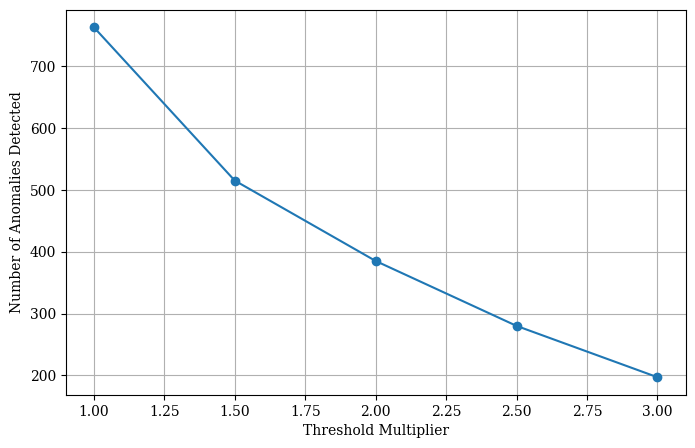

In [ ]:
# range of threshold multipliers
threshold_multipliers = [1, 1.5, 2, 2.5, 3]

num_anomalies_detected = []

# Loop over each threshold multiplier
for multiplier in threshold_multipliers:
    #  dynamic threshold for validation set
    threshold = mean_reconstruction_error_validation + multiplier * std_reconstruction_error_validation

    # Identify anomalies in the validation data based on the dynamic threshold
    anomalies_indices = np.where(reconstruction_errors_validation > threshold)[0]

    # Count the number of anomalies detected
    num_anomalies = len(anomalies_indices)

    # Append the number of anomalies detected to the list
    num_anomalies_detected.append(num_anomalies)

plt.figure(figsize=(8, 5))
plt.plot(threshold_multipliers, num_anomalies_detected, marker='o')
plt.xlabel('Threshold Multiplier')
plt.ylabel('Number of Anomalies Detected')
plt.grid(True)
plt.show()
